In [1]:
import pandas as pd
train_df = pd.read_csv('train.csv', index_col = 'Id')
test_df = pd.read_csv('test.csv', index_col = 'Id')

train_df.dropna(subset = ['SalePrice'], axis = 0, inplace = True)
y = train_df['SalePrice']
x = train_df.drop(columns = ['SalePrice'], axis = 1)


In [2]:
x.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


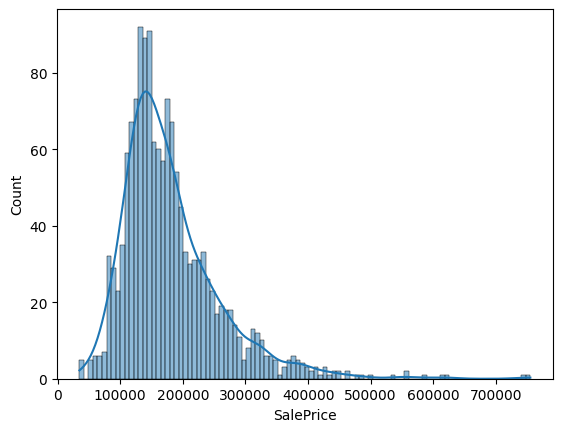

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(x = 'SalePrice', data = train_df, kde = True, bins = 100)
plt.show()

# Drop features which contain too much null value
we use functions to find the values but we will decide how to handle those values by person, not by machine

In [4]:
# Find Missing values columns in x_full
def missing_cols(df: pd.DataFrame, threshold = 0, max_null_percent = 80):# if want to delete columns with specific percent, change value of max_null_percent
    missing_col = (df.isnull().sum()/len(df))*100
   
    missing_col = missing_col[missing_col > threshold].sort_values(ascending = False)
    toomuch_null_col = missing_col[missing_col > max_null_percent].index.tolist()

    print(f'now consider drop columns {toomuch_null_col} because they contains more than {max_null_percent}% null value')
    
    return pd.DataFrame({'null value percent': missing_col})

missing_cols(x)

now consider drop columns ['PoolQC', 'MiscFeature', 'Alley', 'Fence'] because they contains more than 80% null value


,null value percent
PoolQC,99.520548
MiscFeature,96.301370
Alley,93.767123
Fence,80.753425
MasVnrType,59.726027
FireplaceQu,47.260274
LotFrontage,17.739726
GarageType,5.547945
GarageYrBlt,5.547945
GarageFinish,5.547945


In [5]:
# we decided to drop dolumns by our missing_cols function output:
x = x.drop(columns = ['PoolQC', 'MiscFeature', 'Alley', 'Fence'], axis = 1)
test_df_copy  = test_df.copy()
test_df_copy = test_df.drop(columns = ['PoolQC', 'MiscFeature', 'Alley', 'Fence'], axis = 1)

In [6]:
# test if drop successfully
'Alley' in test_df_copy
# we already drop.

False

# Drop outliers rows in our train_df

In [7]:
# spliting num and cat columns
def split_num_cat(df: pd.DataFrame):
    num = df.select_dtypes(include = ['float64', 'int']).columns.tolist()
    cat = df.select_dtypes(include = ['object']).columns.tolist()
    return num, cat

for col in ['MSSubClass', 'MoSold', 'YrSold']:
    if col in x.columns: x[col] = x[col].astype(str)
    if col in test_df_copy.columns: test_df_copy[col] = test_df_copy[col].astype(str)

num, cat = split_num_cat(x)

print('MSSubClass' in num)

False


In [8]:
# by reading the data and our experience:
discrete_num_cols = ['OverallQual','OverallCond','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath',
                'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'MoSold', 'YrSold','MSSubClass']

continuous_num_cols = []
for i in num: 
    if i not in discrete_num_cols:
        continuous_num_cols.append(i)
print(continuous_num_cols)
len(continuous_num_cols)

['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageYrBlt', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']


22

In [9]:
# Delete Outliers in continuous columns(we will delete the rows which contain outliers)

def outlier_detect_IQR(df: pd.DataFrame, continuous_cols: list):
    outlier_indexs = set()
    outlier_value_summary = []

    for i in continuous_cols:
        q1 = df[i].quantile(0.25)
        q3 = df[i].quantile(0.75)
        IQR = q3 - q1
        lower = q1 - 1.5*IQR
        upper = q3 + 1.5*IQR# Outliers are out of q3 + 1.5IQR and q1 - 1.5IQR
        
        mask = ((df[i] < lower) | (df[i] > upper))
        outlier_index = df.index[mask]
        outlier_indexs.update(outlier_index)

        outlier_value_summary.append({
        'column': i,
        'lower': round(q1,2),
        'upper': round(q3,2),
        'n_outliers': sum(mask)

    })
    outlier_value_summary = pd.DataFrame(outlier_value_summary)
    outlier_value_summary = outlier_value_summary.sort_values(by = 'n_outliers', ascending = False)
    return outlier_value_summary, outlier_indexs

outlier_detect_IQR(x, continuous_num_cols)

(           column    lower     upper  n_outliers
 17  EnclosedPorch     0.00      0.00         208
 6      BsmtFinSF2     0.00      0.00         167
 19    ScreenPorch     0.00      0.00         116
 4      MasVnrArea     0.00    166.00          96
 0     LotFrontage    59.00     80.00          88
 16    OpenPorchSF     0.00     68.00          77
 1         LotArea  7553.50  11601.50          69
 8     TotalBsmtSF   795.75   1298.25          61
 21        MiscVal     0.00      0.00          52
 15     WoodDeckSF     0.00    168.00          32
 12      GrLivArea  1129.50   1776.75          31
 7       BsmtUnfSF   223.00    808.00          29
 11   LowQualFinSF     0.00      0.00          26
 18      3SsnPorch     0.00      0.00          24
 14     GarageArea   334.50    576.00          21
 9        1stFlrSF   882.00   1391.25          20
 5      BsmtFinSF1     0.00    712.25           7
 2       YearBuilt  1954.00   2000.00           7
 20       PoolArea     0.00      0.00           7


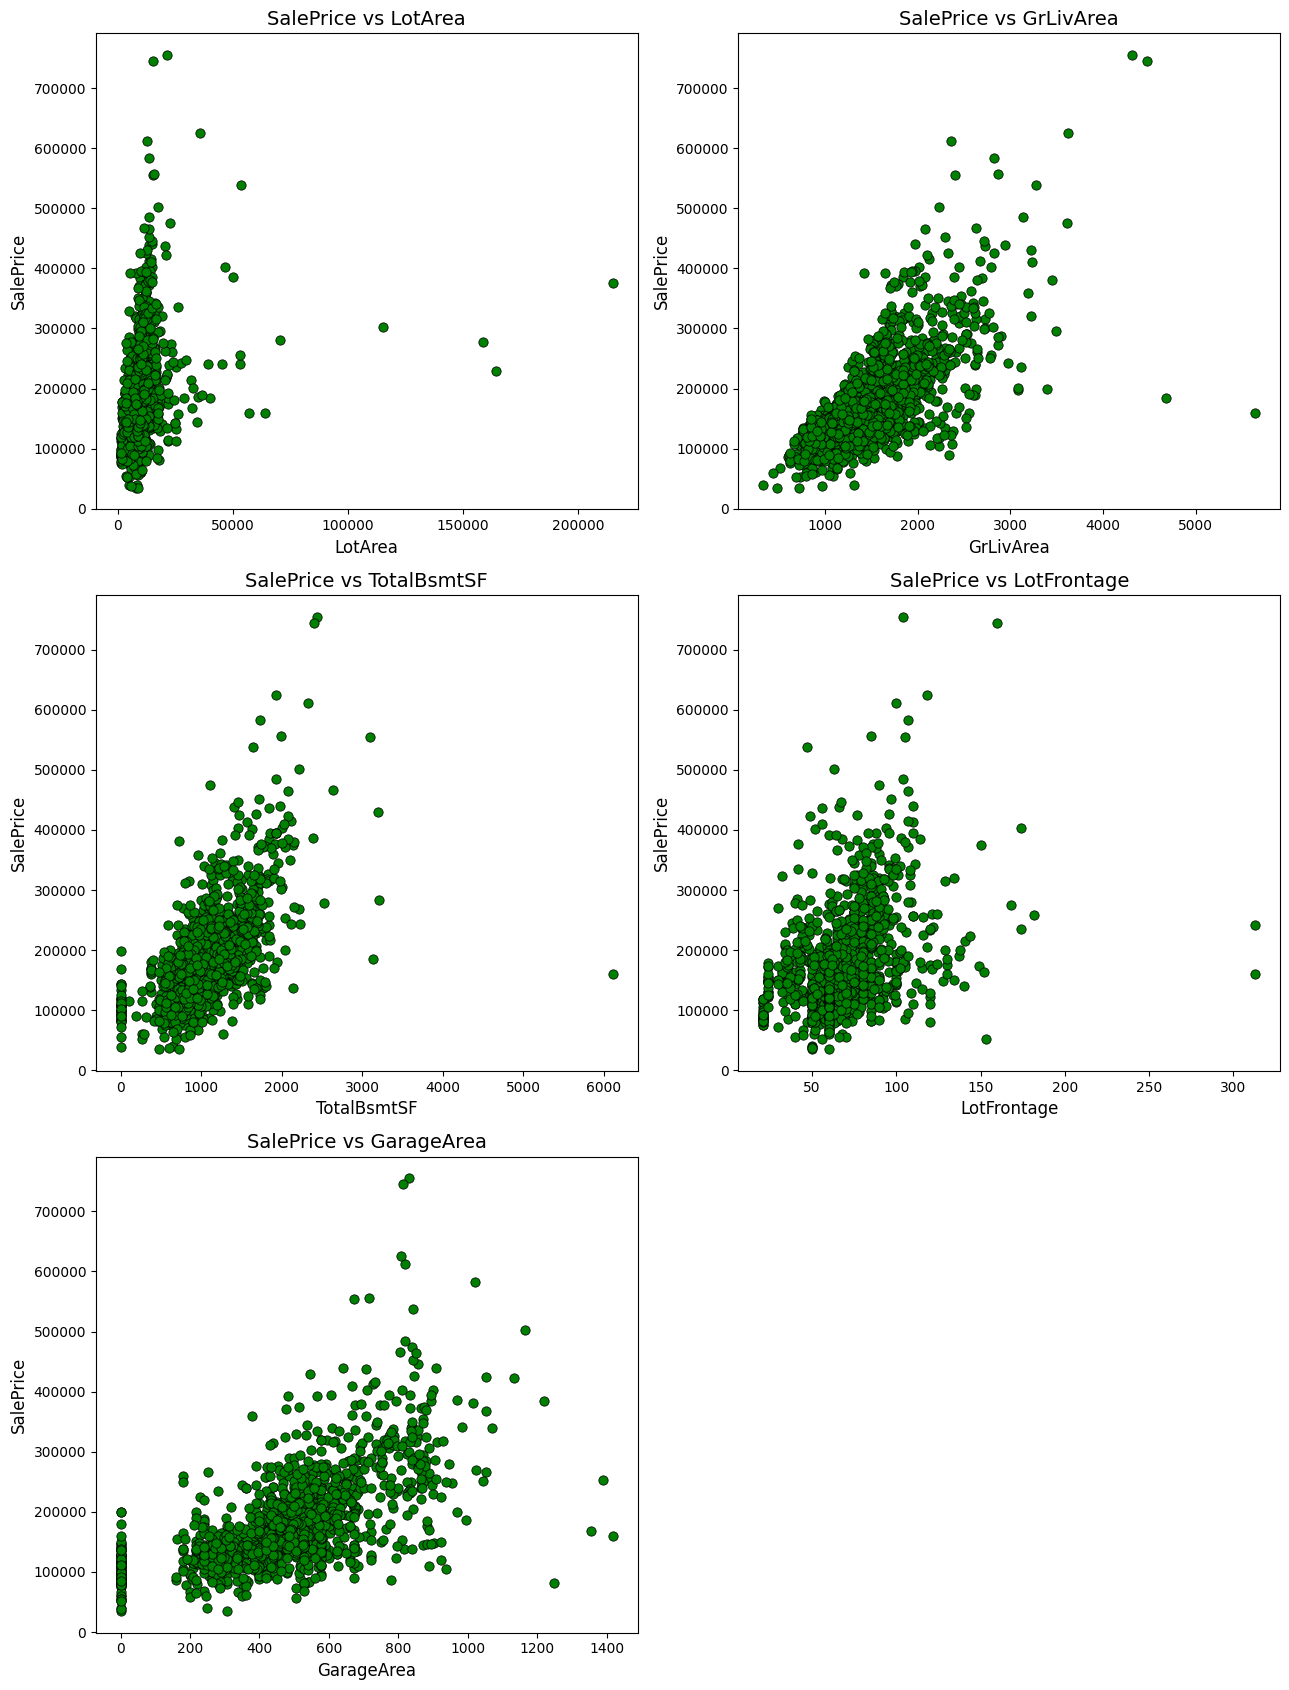

In [10]:
# by above and our experience: we will focus on--> LotArea, GrLivArea, TotalBsmtSF, LotFrontage, GarageArea
# （lower and upper != 0 and related to area）
cols_to_check = ['LotArea', 'GrLivArea', 'TotalBsmtSF', 'LotFrontage', 'GarageArea']

plt.figure(figsize=(13, 17))

for i, col in enumerate(cols_to_check, 1):
    plt.subplot(3, 2, i)
    sns.scatterplot(x = x[col], y = y, s = 45, alpha=1, color = 'green', edgecolor = 'k')
    plt.title(f'SalePrice vs {col}', fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('SalePrice', fontsize=12)

plt.tight_layout()
plt.show()

In [11]:
# Handle Outliers (Hard Threshold)
'''outlier_rules = {
    'LotArea': 100000,
    'GrLivArea': 4000,     
    'TotalBsmtSF': 5000,
    'LotFrontage': 200,
    'GarageArea': 1200
}
for col, threshold in outlier_rules.items():
    if col in x.columns:
        drop_idx = x[x[col] > threshold].index
        x = x.drop(index=drop_idx)
        y = y.drop(index=drop_idx)

(x['LotArea'] > 100000).sum()'''

"outlier_rules = {\n    'LotArea': 100000,\n    'GrLivArea': 4000,     \n    'TotalBsmtSF': 5000,\n    'LotFrontage': 200,\n    'GarageArea': 1200\n}\nfor col, threshold in outlier_rules.items():\n    if col in x.columns:\n        drop_idx = x[x[col] > threshold].index\n        x = x.drop(index=drop_idx)\n        y = y.drop(index=drop_idx)\n\n(x['LotArea'] > 100000).sum()"

# Ordinal_mapping

In [12]:
ordinal_map={'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'NA':0}
bsmtFinType_map={'GLQ':6,'ALQ':5,'BLQ':4,'Rec':3,'LwQ':2,'Unf':1,'NA':0}
bsmtExpo_map={'Gd':4,'Av':3,'Mn':2,'No':1,'NA':0}

ord_col=['ExterQual','ExterCond','BsmtQual','BsmtCond',
         'HeatingQC','KitchenQual','GarageQual','GarageCond']

fin_col=['BsmtFinType1','BsmtFinType2']
expo_col = ['BsmtExposure']

def apply_ordinal(train_df, test_df, cols, mapping, fill=0, dtype='int16'):
    for col in cols:
        if col in train_df.columns:
            train_df[col] = train_df[col].map(mapping).fillna(fill).astype(dtype)
        if col in test_df.columns:
            test_df[col] = test_df[col].map(mapping).fillna(fill).astype(dtype)

apply_ordinal(x, test_df_copy, ord_col, ordinal_map)
apply_ordinal(x, test_df_copy, fin_col, bsmtFinType_map)
apply_ordinal(x, test_df_copy, expo_col, bsmtExpo_map)



In [13]:
test_df_copy['BsmtExposure']
# check

Id
1461    1
1462    1
1463    1
1464    1
1465    1
       ..
2915    1
2916    1
2917    1
2918    3
2919    3
Name: BsmtExposure, Length: 1459, dtype: int16

# Splitting & Columnstransformer

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
import numpy as np

x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.2,random_state = 35)

num_transformer = SimpleImputer(strategy = 'mean')

cat_transformer = Pipeline(steps = [('cat_null', SimpleImputer(strategy = 'most_frequent')),
                                    ('cat_onehot', OneHotEncoder(handle_unknown = 'ignore'))])

In [15]:
num, cat = split_num_cat(x_train)

cols_transformer = ColumnTransformer(transformers = [('num_transformer', num_transformer, num),
                                                    ('cat_transformer', cat_transformer, cat)])

# Find our model parameters

In [16]:
import optuna as opt
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner
cv5 = KFold(n_splits=5, shuffle=True, random_state=35)

def objective(trial):
    params = {
    "n_estimators": trial.suggest_int("n_estimators", 1200, 3600),
    "learning_rate": trial.suggest_float("learning_rate", 0.008, 0.04),  # 降低学习率，提升上限
    "max_depth": trial.suggest_int("max_depth", 4, 10),
    "min_child_weight": trial.suggest_int("min_child_weight", 1, 8),
    "subsample": trial.suggest_float("subsample", 0.6, 0.95),
    "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
    "gamma": trial.suggest_float("gamma", 0.0, 5.0),
    "colsample_bynode": trial.suggest_float("colsample_bynode", 0.6, 1.0),


    # 正则化（B2 核心）
    "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
    "reg_lambda": trial.suggest_float("reg_lambda", 0.5, 3.0),

    # 新增（对稀疏 OHE 非常有效）
    "max_bin": trial.suggest_int("max_bin", 180, 256)

}

    xgb_model = XGBRegressor(
        **params,
        device = 'cpu',
        tree_method =  'hist',
        grow_policy='lossguide',
        n_jobs = 2,
        random_state = 35)
    
    xgb_pipe = Pipeline(steps = [('data_prepross', cols_transformer),('training_xgb', xgb_model)])

    y_log = np.log1p(y)

    score = -cross_val_score(xgb_pipe, x, y_log, cv = cv5, scoring = 'neg_root_mean_squared_error').mean()
    return score

study = opt.create_study(study_name = 'house_xgb_opt', direction = 'minimize', sampler=TPESampler(seed=35), 
                         pruner=MedianPruner(n_warmup_steps=10))
study.optimize(objective, show_progress_bar = True, n_trials = 50, n_jobs = -1)

goat_params = study.best_params
goat_score = round(study.best_value,2)

print(f'our best model parameters are {goat_params}')
print(f'our best model score is {goat_score}')

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-10-21 12:56:28,188] A new study created in memory with name: house_xgb_opt
Best trial: 5. Best value: 0.200116:   2%|▏         | 1/50 [00:02<02:26,  2.99s/it]

[I 2025-10-21 12:56:31,179] Trial 5 finished with value: 0.2001161920534144 and parameters: {'n_estimators': 1227, 'learning_rate': 0.016373453539186258, 'max_depth': 8, 'min_child_weight': 1, 'subsample': 0.6567031735547482, 'colsample_bytree': 0.842252443695644, 'gamma': 4.585275343093626, 'colsample_bynode': 0.9028912122124119, 'reg_alpha': 0.025713681888496653, 'reg_lambda': 2.9490576314234564, 'max_bin': 220}. Best is trial 5 with value: 0.2001161920534144.


Best trial: 2. Best value: 0.181887:   6%|▌         | 3/50 [00:03<00:39,  1.19it/s]

[I 2025-10-21 12:56:31,556] Trial 2 finished with value: 0.1818868898757181 and parameters: {'n_estimators': 1236, 'learning_rate': 0.016733001388435212, 'max_depth': 7, 'min_child_weight': 6, 'subsample': 0.8737313029463356, 'colsample_bytree': 0.9909352726926526, 'gamma': 2.9004383742372966, 'colsample_bynode': 0.7388673638639975, 'reg_alpha': 0.620821921948403, 'reg_lambda': 2.9244830275449476, 'max_bin': 255}. Best is trial 2 with value: 0.1818868898757181.
[I 2025-10-21 12:56:31,664] Trial 7 finished with value: 0.18644936281469135 and parameters: {'n_estimators': 1343, 'learning_rate': 0.023979953428050503, 'max_depth': 10, 'min_child_weight': 7, 'subsample': 0.8026624310107087, 'colsample_bytree': 0.9075902347535776, 'gamma': 3.3882202374118853, 'colsample_bynode': 0.9999276231585921, 'reg_alpha': 0.46451137332550463, 'reg_lambda': 2.261210497384396, 'max_bin': 237}. Best is trial 2 with value: 0.1818868898757181.


Best trial: 6. Best value: 0.143319:  10%|█         | 5/50 [00:03<00:19,  2.35it/s]

[I 2025-10-21 12:56:31,843] Trial 3 finished with value: 0.1775622658528862 and parameters: {'n_estimators': 1606, 'learning_rate': 0.022009222413014555, 'max_depth': 5, 'min_child_weight': 7, 'subsample': 0.8749140122892297, 'colsample_bytree': 0.6670181198468773, 'gamma': 2.560650185434648, 'colsample_bynode': 0.7648274507285001, 'reg_alpha': 0.6769433089102423, 'reg_lambda': 1.481213565787711, 'max_bin': 184}. Best is trial 3 with value: 0.1775622658528862.
[I 2025-10-21 12:56:32,000] Trial 6 finished with value: 0.1433190426220196 and parameters: {'n_estimators': 1385, 'learning_rate': 0.022968151456864153, 'max_depth': 4, 'min_child_weight': 5, 'subsample': 0.944167786502953, 'colsample_bytree': 0.8287279952831894, 'gamma': 0.419362212677864, 'colsample_bynode': 0.6276387997783849, 'reg_alpha': 0.019780536085923894, 'reg_lambda': 0.7654957554075086, 'max_bin': 235}. Best is trial 6 with value: 0.1433190426220196.
[I 2025-10-21 12:56:32,002] Trial 4 finished with value: 0.162502260

Best trial: 1. Best value: 0.14007:  14%|█▍        | 7/50 [00:04<00:16,  2.64it/s] 

[I 2025-10-21 12:56:32,668] Trial 1 finished with value: 0.14007030726327213 and parameters: {'n_estimators': 1681, 'learning_rate': 0.036095253133610124, 'max_depth': 10, 'min_child_weight': 8, 'subsample': 0.7216956990634573, 'colsample_bytree': 0.7933744606623319, 'gamma': 0.288833675786333, 'colsample_bynode': 0.9200989518916604, 'reg_alpha': 0.4214223499233475, 'reg_lambda': 2.6131407014659005, 'max_bin': 199}. Best is trial 1 with value: 0.14007030726327213.


Best trial: 1. Best value: 0.14007:  16%|█▌        | 8/50 [00:04<00:15,  2.67it/s]

[I 2025-10-21 12:56:33,031] Trial 0 finished with value: 0.15364780916650692 and parameters: {'n_estimators': 1940, 'learning_rate': 0.02158462035798111, 'max_depth': 4, 'min_child_weight': 4, 'subsample': 0.8210570018996698, 'colsample_bytree': 0.8744767031855293, 'gamma': 0.8551690483206636, 'colsample_bynode': 0.6133789844732159, 'reg_alpha': 0.7984486735181966, 'reg_lambda': 2.6180653358233203, 'max_bin': 200}. Best is trial 1 with value: 0.14007030726327213.


Best trial: 1. Best value: 0.14007:  18%|█▊        | 9/50 [00:07<00:35,  1.17it/s]

[I 2025-10-21 12:56:35,154] Trial 13 finished with value: 0.1538052033824575 and parameters: {'n_estimators': 1209, 'learning_rate': 0.02428768541316563, 'max_depth': 6, 'min_child_weight': 3, 'subsample': 0.8055839807053867, 'colsample_bytree': 0.8833095778152754, 'gamma': 1.0605394889649056, 'colsample_bynode': 0.7118048161126226, 'reg_alpha': 0.010692092079799487, 'reg_lambda': 1.9548202614181056, 'max_bin': 249}. Best is trial 1 with value: 0.14007030726327213.
[I 2025-10-21 12:56:35,232] Trial 11 finished with value: 0.19605039310668265 and parameters: {'n_estimators': 1606, 'learning_rate': 0.026635444638306395, 'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.633980859868691, 'colsample_bytree': 0.6711814738495337, 'gamma': 4.03494522497592, 'colsample_bynode': 0.680081992424923, 'reg_alpha': 0.7972218087806481, 'reg_lambda': 0.7164771440627553, 'max_bin': 212}. Best is trial 1 with value: 0.14007030726327213.


Best trial: 1. Best value: 0.14007:  22%|██▏       | 11/50 [00:08<00:27,  1.40it/s]

[I 2025-10-21 12:56:36,218] Trial 8 finished with value: 0.1816921850936266 and parameters: {'n_estimators': 2370, 'learning_rate': 0.02382841040705797, 'max_depth': 7, 'min_child_weight': 7, 'subsample': 0.7469021719466875, 'colsample_bytree': 0.9708230869412044, 'gamma': 2.995725721904888, 'colsample_bynode': 0.7964503866557208, 'reg_alpha': 0.4743549514872779, 'reg_lambda': 2.744685021817227, 'max_bin': 182}. Best is trial 1 with value: 0.14007030726327213.


Best trial: 1. Best value: 0.14007:  24%|██▍       | 12/50 [00:08<00:25,  1.47it/s]

[I 2025-10-21 12:56:36,788] Trial 9 finished with value: 0.16558859727496386 and parameters: {'n_estimators': 2535, 'learning_rate': 0.03611100931909164, 'max_depth': 9, 'min_child_weight': 2, 'subsample': 0.8030699633444399, 'colsample_bytree': 0.8066497795225351, 'gamma': 1.6822143927151618, 'colsample_bynode': 0.6680947871315063, 'reg_alpha': 0.8250066478692637, 'reg_lambda': 0.7065673172145424, 'max_bin': 200}. Best is trial 1 with value: 0.14007030726327213.
[I 2025-10-21 12:56:36,790] Trial 10 finished with value: 0.16455800598043374 and parameters: {'n_estimators': 1765, 'learning_rate': 0.009545338998675537, 'max_depth': 4, 'min_child_weight': 2, 'subsample': 0.6890407458183362, 'colsample_bytree': 0.8309626440311484, 'gamma': 1.4494164607799704, 'colsample_bynode': 0.8978474080342874, 'reg_alpha': 0.867509759077417, 'reg_lambda': 2.877966919623911, 'max_bin': 204}. Best is trial 1 with value: 0.14007030726327213.


Best trial: 12. Best value: 0.13535:  28%|██▊       | 14/50 [00:09<00:19,  1.89it/s]

[I 2025-10-21 12:56:37,409] Trial 12 finished with value: 0.13535004479565657 and parameters: {'n_estimators': 2371, 'learning_rate': 0.023278514569601765, 'max_depth': 4, 'min_child_weight': 2, 'subsample': 0.7962593326680872, 'colsample_bytree': 0.651765656868147, 'gamma': 0.22375338058149286, 'colsample_bynode': 0.9474276344524357, 'reg_alpha': 0.03224001317630498, 'reg_lambda': 1.2749825748201224, 'max_bin': 198}. Best is trial 12 with value: 0.13535004479565657.


Best trial: 12. Best value: 0.13535:  32%|███▏      | 16/50 [00:09<00:13,  2.45it/s]

[I 2025-10-21 12:56:37,754] Trial 15 finished with value: 0.19356794308373332 and parameters: {'n_estimators': 1899, 'learning_rate': 0.008402024188461752, 'max_depth': 7, 'min_child_weight': 2, 'subsample': 0.8640705100548031, 'colsample_bytree': 0.9403237382447747, 'gamma': 3.949951835440512, 'colsample_bynode': 0.7894943183388408, 'reg_alpha': 0.7428340395674511, 'reg_lambda': 1.9690431981999552, 'max_bin': 201}. Best is trial 12 with value: 0.13535004479565657.
[I 2025-10-21 12:56:37,911] Trial 16 finished with value: 0.18522559454576523 and parameters: {'n_estimators': 1319, 'learning_rate': 0.017744921981837226, 'max_depth': 4, 'min_child_weight': 2, 'subsample': 0.8733010609173275, 'colsample_bytree': 0.8829214845647122, 'gamma': 3.293234662893887, 'colsample_bynode': 0.6987468714877545, 'reg_alpha': 0.4999463742694795, 'reg_lambda': 1.2444911803761882, 'max_bin': 221}. Best is trial 12 with value: 0.13535004479565657.


Best trial: 12. Best value: 0.13535:  34%|███▍      | 17/50 [00:11<00:21,  1.56it/s]

[I 2025-10-21 12:56:39,231] Trial 14 finished with value: 0.19437244850318522 and parameters: {'n_estimators': 2950, 'learning_rate': 0.01941450197064765, 'max_depth': 7, 'min_child_weight': 5, 'subsample': 0.7186356421186583, 'colsample_bytree': 0.9226593265343679, 'gamma': 4.296609934762535, 'colsample_bynode': 0.9360332855136337, 'reg_alpha': 0.11785631448279177, 'reg_lambda': 2.709604128626252, 'max_bin': 251}. Best is trial 12 with value: 0.13535004479565657.


Best trial: 12. Best value: 0.13535:  36%|███▌      | 18/50 [00:13<00:32,  1.02s/it]

[I 2025-10-21 12:56:41,282] Trial 17 finished with value: 0.1642987512599392 and parameters: {'n_estimators': 3034, 'learning_rate': 0.03875319697837275, 'max_depth': 10, 'min_child_weight': 8, 'subsample': 0.7129963730279564, 'colsample_bytree': 0.7546591122591884, 'gamma': 1.7476452583286166, 'colsample_bynode': 0.9685785036405921, 'reg_alpha': 0.3198731700813226, 'reg_lambda': 1.5056523844555298, 'max_bin': 183}. Best is trial 12 with value: 0.13535004479565657.


Best trial: 12. Best value: 0.13535:  38%|███▊      | 19/50 [00:16<00:50,  1.62s/it]

[I 2025-10-21 12:56:44,464] Trial 18 finished with value: 0.13753646247635748 and parameters: {'n_estimators': 3554, 'learning_rate': 0.03777276154432181, 'max_depth': 10, 'min_child_weight': 8, 'subsample': 0.9369401300718421, 'colsample_bytree': 0.7773166599539422, 'gamma': 0.11057624902505381, 'colsample_bynode': 0.9301034332871666, 'reg_alpha': 0.238915247214233, 'reg_lambda': 1.6018226408524687, 'max_bin': 202}. Best is trial 12 with value: 0.13535004479565657.
[I 2025-10-21 12:56:44,467] Trial 22 finished with value: 0.1360510944893986 and parameters: {'n_estimators': 3345, 'learning_rate': 0.033373169085828484, 'max_depth': 10, 'min_child_weight': 8, 'subsample': 0.7348589824012726, 'colsample_bytree': 0.6059174811426633, 'gamma': 0.22390408392998842, 'colsample_bynode': 0.9939701707103986, 'reg_alpha': 0.2285542963871692, 'reg_lambda': 1.4033725464861069, 'max_bin': 190}. Best is trial 12 with value: 0.13535004479565657.


Best trial: 12. Best value: 0.13535:  42%|████▏     | 21/50 [00:17<00:30,  1.07s/it]

[I 2025-10-21 12:56:45,206] Trial 20 finished with value: 0.13628058415655905 and parameters: {'n_estimators': 3091, 'learning_rate': 0.0393689136603251, 'max_depth': 10, 'min_child_weight': 5, 'subsample': 0.9373714115661167, 'colsample_bytree': 0.7645041773365411, 'gamma': 0.045636626944137226, 'colsample_bynode': 0.988363856686534, 'reg_alpha': 0.23964866242035804, 'reg_lambda': 1.3312433180549883, 'max_bin': 226}. Best is trial 12 with value: 0.13535004479565657.


Best trial: 21. Best value: 0.131805:  44%|████▍     | 22/50 [00:17<00:24,  1.14it/s]

[I 2025-10-21 12:56:45,471] Trial 21 finished with value: 0.13180456758432524 and parameters: {'n_estimators': 3164, 'learning_rate': 0.03363408264793066, 'max_depth': 10, 'min_child_weight': 8, 'subsample': 0.7358800334312079, 'colsample_bytree': 0.7431094986795469, 'gamma': 0.05755759086778439, 'colsample_bynode': 0.9996160366311387, 'reg_alpha': 0.2208555884355486, 'reg_lambda': 1.3521168828667633, 'max_bin': 193}. Best is trial 21 with value: 0.13180456758432524.


Best trial: 23. Best value: 0.128785:  48%|████▊     | 24/50 [00:19<00:24,  1.06it/s]

[I 2025-10-21 12:56:47,672] Trial 23 finished with value: 0.1287849053379489 and parameters: {'n_estimators': 3373, 'learning_rate': 0.03161983240300927, 'max_depth': 10, 'min_child_weight': 8, 'subsample': 0.7350055182548527, 'colsample_bytree': 0.6049906096723683, 'gamma': 0.027204454518059473, 'colsample_bynode': 0.9871502349583069, 'reg_alpha': 0.2743513913359844, 'reg_lambda': 1.510779075224781, 'max_bin': 193}. Best is trial 23 with value: 0.1287849053379489.
[I 2025-10-21 12:56:47,863] Trial 19 finished with value: 0.13515461582547197 and parameters: {'n_estimators': 2044, 'learning_rate': 0.03974167453284537, 'max_depth': 10, 'min_child_weight': 5, 'subsample': 0.9425623120946011, 'colsample_bytree': 0.7504690686273198, 'gamma': 0.002861415456784755, 'colsample_bynode': 0.9722160692434382, 'reg_alpha': 0.2701560672534398, 'reg_lambda': 1.3229567030775071, 'max_bin': 223}. Best is trial 23 with value: 0.1287849053379489.


Best trial: 23. Best value: 0.128785:  50%|█████     | 25/50 [00:20<00:20,  1.25it/s]

[I 2025-10-21 12:56:48,294] Trial 24 finished with value: 0.13016484604733153 and parameters: {'n_estimators': 3333, 'learning_rate': 0.0305351637197006, 'max_depth': 10, 'min_child_weight': 8, 'subsample': 0.7507018937474553, 'colsample_bytree': 0.6159019133429726, 'gamma': 0.04733121227656045, 'colsample_bynode': 0.9874042073556593, 'reg_alpha': 0.3106259832387243, 'reg_lambda': 1.3691827524580595, 'max_bin': 190}. Best is trial 23 with value: 0.1287849053379489.


Best trial: 23. Best value: 0.128785:  54%|█████▍    | 27/50 [00:21<00:13,  1.67it/s]

[I 2025-10-21 12:56:49,094] Trial 25 finished with value: 0.13276425221938618 and parameters: {'n_estimators': 3530, 'learning_rate': 0.030484795759220095, 'max_depth': 9, 'min_child_weight': 4, 'subsample': 0.7502534932499851, 'colsample_bytree': 0.6316686488083565, 'gamma': 0.15650674198820774, 'colsample_bynode': 0.846523550797232, 'reg_alpha': 0.2250156336950977, 'reg_lambda': 2.330122706599354, 'max_bin': 193}. Best is trial 23 with value: 0.1287849053379489.
[I 2025-10-21 12:56:49,199] Trial 27 finished with value: 0.16893879733338432 and parameters: {'n_estimators': 2274, 'learning_rate': 0.030331117338450134, 'max_depth': 9, 'min_child_weight': 4, 'subsample': 0.7710084632567795, 'colsample_bytree': 0.6002576494843233, 'gamma': 2.101880486720013, 'colsample_bynode': 0.8395624538980364, 'reg_alpha': 0.16690245635676576, 'reg_lambda': 1.106536805657331, 'max_bin': 190}. Best is trial 23 with value: 0.1287849053379489.
[I 2025-10-21 12:56:49,222] Trial 26 finished with value: 0.16

Best trial: 23. Best value: 0.128785:  58%|█████▊    | 29/50 [00:24<00:23,  1.10s/it]

[I 2025-10-21 12:56:52,627] Trial 28 finished with value: 0.15045770135162023 and parameters: {'n_estimators': 3541, 'learning_rate': 0.03294301618772441, 'max_depth': 9, 'min_child_weight': 4, 'subsample': 0.7770824208553927, 'colsample_bytree': 0.6164821237489899, 'gamma': 0.8541680822461655, 'colsample_bynode': 0.9876716828859043, 'reg_alpha': 0.20660907111654125, 'reg_lambda': 1.1581081217400968, 'max_bin': 190}. Best is trial 23 with value: 0.1287849053379489.
[I 2025-10-21 12:56:52,646] Trial 29 finished with value: 0.14848136242728155 and parameters: {'n_estimators': 3600, 'learning_rate': 0.03095625365792906, 'max_depth': 9, 'min_child_weight': 6, 'subsample': 0.7597098553739492, 'colsample_bytree': 0.6010252412711465, 'gamma': 0.749145544713681, 'colsample_bynode': 0.8664372685692722, 'reg_alpha': 0.19894371585115608, 'reg_lambda': 1.1128089071176663, 'max_bin': 192}. Best is trial 23 with value: 0.1287849053379489.


Best trial: 23. Best value: 0.128785:  62%|██████▏   | 31/50 [00:25<00:15,  1.25it/s]

[I 2025-10-21 12:56:53,296] Trial 30 finished with value: 0.15008407198132812 and parameters: {'n_estimators': 2390, 'learning_rate': 0.031504188841984464, 'max_depth': 9, 'min_child_weight': 6, 'subsample': 0.7657136556235046, 'colsample_bytree': 0.6012409592288515, 'gamma': 0.664558941194717, 'colsample_bynode': 0.8434180188706225, 'reg_alpha': 0.9898217672702806, 'reg_lambda': 1.1155504276624264, 'max_bin': 209}. Best is trial 23 with value: 0.1287849053379489.


Best trial: 23. Best value: 0.128785:  64%|██████▍   | 32/50 [00:26<00:15,  1.19it/s]

[I 2025-10-21 12:56:54,280] Trial 31 finished with value: 0.1511028576919014 and parameters: {'n_estimators': 2711, 'learning_rate': 0.03036965996737154, 'max_depth': 9, 'min_child_weight': 6, 'subsample': 0.7617895432623427, 'colsample_bytree': 0.717478947300415, 'gamma': 0.7343672266521827, 'colsample_bynode': 0.8712383491195907, 'reg_alpha': 0.9959870620496248, 'reg_lambda': 1.1224310431176951, 'max_bin': 212}. Best is trial 23 with value: 0.1287849053379489.


Best trial: 23. Best value: 0.128785:  66%|██████▌   | 33/50 [00:26<00:14,  1.20it/s]

[I 2025-10-21 12:56:55,073] Trial 32 finished with value: 0.14746898662387528 and parameters: {'n_estimators': 3296, 'learning_rate': 0.030338125160713273, 'max_depth': 9, 'min_child_weight': 6, 'subsample': 0.6859912739036964, 'colsample_bytree': 0.6115155684460051, 'gamma': 0.6884389018022397, 'colsample_bynode': 0.8597435776013093, 'reg_alpha': 0.33912258877912044, 'reg_lambda': 1.0644068274820435, 'max_bin': 190}. Best is trial 23 with value: 0.1287849053379489.
[I 2025-10-21 12:56:55,169] Trial 34 finished with value: 0.1514779338897762 and parameters: {'n_estimators': 2741, 'learning_rate': 0.028262480572776295, 'max_depth': 9, 'min_child_weight': 6, 'subsample': 0.677539922164927, 'colsample_bytree': 0.7007650393080029, 'gamma': 0.8791532671411353, 'colsample_bynode': 0.8846437589958414, 'reg_alpha': 0.3419119548927495, 'reg_lambda': 1.7248035896961535, 'max_bin': 212}. Best is trial 23 with value: 0.1287849053379489.


Best trial: 23. Best value: 0.128785:  70%|███████   | 35/50 [00:27<00:08,  1.80it/s]

[I 2025-10-21 12:56:55,382] Trial 35 finished with value: 0.15446568382254253 and parameters: {'n_estimators': 2802, 'learning_rate': 0.027402173533326052, 'max_depth': 8, 'min_child_weight': 6, 'subsample': 0.6839955568998028, 'colsample_bytree': 0.7015228174096217, 'gamma': 0.9477625084372001, 'colsample_bynode': 0.8825804090059599, 'reg_alpha': 0.9921419001972736, 'reg_lambda': 1.7850840222107232, 'max_bin': 212}. Best is trial 23 with value: 0.1287849053379489.


Best trial: 23. Best value: 0.128785:  72%|███████▏  | 36/50 [00:28<00:09,  1.49it/s]

[I 2025-10-21 12:56:56,451] Trial 33 finished with value: 0.14864883748587002 and parameters: {'n_estimators': 3277, 'learning_rate': 0.029673528225266817, 'max_depth': 9, 'min_child_weight': 6, 'subsample': 0.6831642802879137, 'colsample_bytree': 0.71483105955244, 'gamma': 0.7363110810298279, 'colsample_bynode': 0.8686613952770973, 'reg_alpha': 0.33705409764818695, 'reg_lambda': 1.0585378805503023, 'max_bin': 208}. Best is trial 23 with value: 0.1287849053379489.


Best trial: 23. Best value: 0.128785:  74%|███████▍  | 37/50 [00:30<00:13,  1.03s/it]

[I 2025-10-21 12:56:58,603] Trial 37 finished with value: 0.15430502602165025 and parameters: {'n_estimators': 2718, 'learning_rate': 0.027561395439453983, 'max_depth': 8, 'min_child_weight': 7, 'subsample': 0.6913511273872045, 'colsample_bytree': 0.6933785238358923, 'gamma': 1.0983874918146197, 'colsample_bynode': 0.9605620103428935, 'reg_alpha': 0.3390701425986798, 'reg_lambda': 1.744066041136029, 'max_bin': 212}. Best is trial 23 with value: 0.1287849053379489.


Best trial: 23. Best value: 0.128785:  76%|███████▌  | 38/50 [00:30<00:10,  1.13it/s]

[I 2025-10-21 12:56:59,074] Trial 36 finished with value: 0.14815389820164146 and parameters: {'n_estimators': 2781, 'learning_rate': 0.02700881183624186, 'max_depth': 8, 'min_child_weight': 6, 'subsample': 0.6969649957529571, 'colsample_bytree': 0.6974898516413109, 'gamma': 0.7088889262625315, 'colsample_bynode': 0.8981045419520155, 'reg_alpha': 0.3367410648996371, 'reg_lambda': 1.686288694500787, 'max_bin': 213}. Best is trial 23 with value: 0.1287849053379489.


Best trial: 23. Best value: 0.128785:  78%|███████▊  | 39/50 [00:32<00:10,  1.01it/s]

[I 2025-10-21 12:57:00,347] Trial 38 finished with value: 0.15573965316768862 and parameters: {'n_estimators': 3285, 'learning_rate': 0.028510691898789707, 'max_depth': 8, 'min_child_weight': 7, 'subsample': 0.6845822704599855, 'colsample_bytree': 0.643693057893338, 'gamma': 1.1639903898043693, 'colsample_bynode': 0.9612347844476344, 'reg_alpha': 0.3171365121662334, 'reg_lambda': 1.8203917602319348, 'max_bin': 195}. Best is trial 23 with value: 0.1287849053379489.


Best trial: 23. Best value: 0.128785:  80%|████████  | 40/50 [00:33<00:09,  1.00it/s]

[I 2025-10-21 12:57:01,360] Trial 39 finished with value: 0.1559852831801421 and parameters: {'n_estimators': 3303, 'learning_rate': 0.028488943897791504, 'max_depth': 8, 'min_child_weight': 7, 'subsample': 0.6871587038898108, 'colsample_bytree': 0.6912941623448527, 'gamma': 1.1974154312492133, 'colsample_bynode': 0.9622932721439926, 'reg_alpha': 0.3440785708068367, 'reg_lambda': 1.7212731208883998, 'max_bin': 195}. Best is trial 23 with value: 0.1287849053379489.


Best trial: 23. Best value: 0.128785:  82%|████████▏ | 41/50 [00:33<00:08,  1.09it/s]

[I 2025-10-21 12:57:02,079] Trial 42 finished with value: 0.14362163400539546 and parameters: {'n_estimators': 3285, 'learning_rate': 0.03490098991178713, 'max_depth': 8, 'min_child_weight': 7, 'subsample': 0.7092410272803192, 'colsample_bytree': 0.6418496916215508, 'gamma': 0.4927834558292091, 'colsample_bynode': 0.9574633578430589, 'reg_alpha': 0.1124146960235867, 'reg_lambda': 2.36568320406273, 'max_bin': 197}. Best is trial 23 with value: 0.1287849053379489.


Best trial: 23. Best value: 0.128785:  84%|████████▍ | 42/50 [00:34<00:06,  1.32it/s]

[I 2025-10-21 12:57:02,438] Trial 40 finished with value: 0.14114042528478024 and parameters: {'n_estimators': 3292, 'learning_rate': 0.027392764964994938, 'max_depth': 8, 'min_child_weight': 7, 'subsample': 0.6944435611202922, 'colsample_bytree': 0.6393533167633595, 'gamma': 0.409075293877333, 'colsample_bynode': 0.9529323665588599, 'reg_alpha': 0.1144939008570676, 'reg_lambda': 1.752869978481733, 'max_bin': 194}. Best is trial 23 with value: 0.1287849053379489.


Best trial: 23. Best value: 0.128785:  86%|████████▌ | 43/50 [00:34<00:04,  1.62it/s]

[I 2025-10-21 12:57:02,721] Trial 41 finished with value: 0.1424352185137276 and parameters: {'n_estimators': 3346, 'learning_rate': 0.03469106490466502, 'max_depth': 8, 'min_child_weight': 7, 'subsample': 0.8298022412245933, 'colsample_bytree': 0.6505081827659669, 'gamma': 0.4126461258835782, 'colsample_bynode': 0.9537622118058677, 'reg_alpha': 0.11350866449851946, 'reg_lambda': 2.45658604205945, 'max_bin': 196}. Best is trial 23 with value: 0.1287849053379489.


Best trial: 23. Best value: 0.128785:  88%|████████▊ | 44/50 [00:35<00:03,  1.52it/s]

[I 2025-10-21 12:57:03,472] Trial 43 finished with value: 0.14302568854400718 and parameters: {'n_estimators': 3371, 'learning_rate': 0.03400113493335274, 'max_depth': 8, 'min_child_weight': 7, 'subsample': 0.6011239836908521, 'colsample_bytree': 0.6444377075872797, 'gamma': 0.4489465605127146, 'colsample_bynode': 0.9560031232808707, 'reg_alpha': 0.6043563601422618, 'reg_lambda': 2.331018652284185, 'max_bin': 197}. Best is trial 23 with value: 0.1287849053379489.


Best trial: 23. Best value: 0.128785:  90%|█████████ | 45/50 [00:37<00:05,  1.03s/it]

[I 2025-10-21 12:57:05,376] Trial 44 finished with value: 0.1417729436008583 and parameters: {'n_estimators': 3413, 'learning_rate': 0.03458323941557315, 'max_depth': 10, 'min_child_weight': 8, 'subsample': 0.8421219894857619, 'colsample_bytree': 0.6425140583800736, 'gamma': 0.39607444634280586, 'colsample_bynode': 0.9216958545452246, 'reg_alpha': 0.12305847463642902, 'reg_lambda': 2.405983816869459, 'max_bin': 196}. Best is trial 23 with value: 0.1287849053379489.
[I 2025-10-21 12:57:05,445] Trial 45 finished with value: 0.14534854062301994 and parameters: {'n_estimators': 3402, 'learning_rate': 0.03484793626174758, 'max_depth': 10, 'min_child_weight': 8, 'subsample': 0.8392096100380559, 'colsample_bytree': 0.6409850454143072, 'gamma': 0.48171201795249796, 'colsample_bynode': 0.917776321061703, 'reg_alpha': 0.5986346864937812, 'reg_lambda': 2.4067259685164553, 'max_bin': 197}. Best is trial 23 with value: 0.1287849053379489.


Best trial: 23. Best value: 0.128785:  94%|█████████▍| 47/50 [00:37<00:02,  1.41it/s]

[I 2025-10-21 12:57:06,056] Trial 48 finished with value: 0.14338284086704858 and parameters: {'n_estimators': 2052, 'learning_rate': 0.03524573942963554, 'max_depth': 10, 'min_child_weight': 8, 'subsample': 0.840180483992116, 'colsample_bytree': 0.738804114679433, 'gamma': 0.3849669586077949, 'colsample_bynode': 0.9163813708824304, 'reg_alpha': 0.41463985104988377, 'reg_lambda': 0.9065165277645046, 'max_bin': 180}. Best is trial 23 with value: 0.1287849053379489.


Best trial: 23. Best value: 0.128785:  96%|█████████▌| 48/50 [00:38<00:01,  1.67it/s]

[I 2025-10-21 12:57:06,309] Trial 46 finished with value: 0.14301756881643377 and parameters: {'n_estimators': 3452, 'learning_rate': 0.03575075380099382, 'max_depth': 10, 'min_child_weight': 8, 'subsample': 0.7325871342484568, 'colsample_bytree': 0.6370016017297716, 'gamma': 0.4409678472836056, 'colsample_bynode': 0.755887516693845, 'reg_alpha': 0.5901440935803823, 'reg_lambda': 2.3970719938371987, 'max_bin': 185}. Best is trial 23 with value: 0.1287849053379489.


Best trial: 23. Best value: 0.128785:  98%|█████████▊| 49/50 [00:38<00:00,  1.87it/s]

[I 2025-10-21 12:57:06,661] Trial 47 finished with value: 0.14506369504632438 and parameters: {'n_estimators': 3437, 'learning_rate': 0.03481603595295482, 'max_depth': 10, 'min_child_weight': 8, 'subsample': 0.8484662803877625, 'colsample_bytree': 0.6350096114504731, 'gamma': 0.4552980835367251, 'colsample_bynode': 0.9166943760419323, 'reg_alpha': 0.5672101085559802, 'reg_lambda': 2.2866447317747047, 'max_bin': 186}. Best is trial 23 with value: 0.1287849053379489.


Best trial: 23. Best value: 0.128785: 100%|██████████| 50/50 [00:39<00:00,  1.25it/s]

[I 2025-10-21 12:57:08,045] Trial 49 finished with value: 0.12895445859659543 and parameters: {'n_estimators': 2081, 'learning_rate': 0.03564467876864433, 'max_depth': 10, 'min_child_weight': 8, 'subsample': 0.6102030532529048, 'colsample_bytree': 0.7407315497933215, 'gamma': 0.010321158747477265, 'colsample_bynode': 0.9249267217547026, 'reg_alpha': 0.564177667115008, 'reg_lambda': 1.4677922029008146, 'max_bin': 185}. Best is trial 23 with value: 0.1287849053379489.
our best model parameters are {'n_estimators': 3373, 'learning_rate': 0.03161983240300927, 'max_depth': 10, 'min_child_weight': 8, 'subsample': 0.7350055182548527, 'colsample_bytree': 0.6049906096723683, 'gamma': 0.027204454518059473, 'colsample_bynode': 0.9871502349583069, 'reg_alpha': 0.2743513913359844, 'reg_lambda': 1.510779075224781, 'max_bin': 193}
our best model score is 0.13


# Deliver our prediction!

In [17]:

final_xgb_model = XGBRegressor(
        **goat_params,
        device = 'cpu',
        tree_method =  'hist',
        n_jobs=2, 
        grow_policy='lossguide',
        random_state = 35)
    
final_xgb_pipe = Pipeline(steps = [('data_prepross', cols_transformer),('training_xgb', final_xgb_model)])

final_xgb_pipe.fit(x, np.log1p(y))
y_prediction_log = final_xgb_pipe.predict(test_df_copy)
y_prediction = np.expm1(y_prediction_log)

output = pd.DataFrame({'Id': test_df_copy.index,
                       'SalePrice': y_prediction})
output.to_csv('submission_feature_engineering.csv', index = False)